In [1]:
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brian2.only import *

%load_ext autoreload
%autoreload 1

%aimport numpy_
%aimport spatial
%aimport model
%aimport inputs
%aimport util
%aimport spike_utils

# for the IDE:
import numpy_ as np
import spatial, model, inputs

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes

In [2]:
rng = np.random.default_rng()
set_device('cpp_standalone')
prefs.devices.cpp_standalone.openmp_threads = mp.cpu_count() - 2
defaultclock.dt = 1*ms

In [3]:
N = 1000
inhibitory_ratio = .2

params = {
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': np.log(1),
    'w_inh_sigma': 0.2,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 30,
    'w_exc_mean': np.log(1.5),
    'w_exc_sigma': 0.2,

    # Stimulus
    'N_stimuli': 10,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 10,
    'sequence_count': 10,
    'ISI': 500*ms,
}

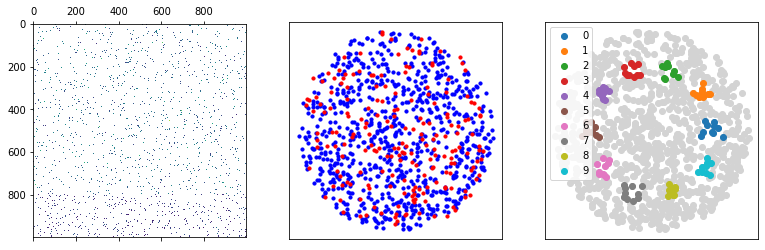

In [4]:
# X, Y, W, D = spatial.create_weights(params, rng)
f = np.load('largeB.npz')
X, Y, W, D = f['X']*meter, f['Y']*meter, f['W'], f['D']
Xstim, Ystim = spatial.create_stimulus_locations(params)

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs[0].matshow(W)
axs[1].scatter(X[:params['N_exc']], Y[:params['N_exc']], s=10, c='b')
axs[1].scatter(X[params['N_exc']:], Y[params['N_exc']:], s=10, c='r')

idx = spatial.get_stimulated(X, Y, Xstim, Ystim, params)
axs[2].scatter(X, Y, c='lightgrey')
for i, row in enumerate(idx):
    axs[2].scatter(X[row], Y[row], label=i)
axs[2].legend()

for ax in axs[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
# Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
# Net.run(30*second)

In [6]:
def raster(net):
    fig, ax = plt.subplots(figsize=(20,5))
    offset = 0
    ticks, mticks, labels = [], [], []
    for k in ['Exc', 'Inh']:
        plt.plot(net[f'SpikeMon_{k}'].t/second, net[f'SpikeMon_{k}'].i + offset, ',k')
        ticks.append(offset)
        mticks.append(offset+net[k].N/2)
        labels.append(k)
        offset += net[k].N
        print(k, len(net[f'SpikeMon_{k}'].i)/net.t/net[k].N)
    ticks.append(offset)
    ax.set_yticks(ticks)
    ax.set_yticks(mticks, minor=True)
    ax.set_yticklabels(labels, minor=True)
    ax.set_xlabel('seconds')
    return ax

In [7]:
# raster(Net);

In [8]:
def get_episode_spikes(Net, params, episode=0, sorted=True):
    offset = 0
    T, I = [], []
    episode_duration = params['ISI']*params['sequence_length']*params['sequence_count']
    full_episode_duration = params['settling_period'] + episode_duration
    t0 = episode * full_episode_duration + params['settling_period']
    for k in ['Exc', 'Inh']:
        t, i = Net[f'SpikeMon_{k}'].t, Net[f'SpikeMon_{k}'].i + offset
        offset += Net[k].N
        mask = (t > t0) & (t < t0 + episode_duration)
        T.append(t[mask])
        I.append(i[mask])
    T = np.concatenate(T) - t0
    I = np.concatenate(I)
    if sorted:
        sorted = np.argsort(T)
        T, I = T[sorted], I[sorted]
    return I, T

In [9]:
def get_neuron_spike_counts(N, pulsed_i, sequence, target_item):
    numspikes = np.zeros(N, dtype=int)
    for pulse_idx, pulse_item in enumerate(sequence):
        if pulse_item == target_item:
            np.add.at(numspikes, pulsed_i[pulse_idx], 1)
    return numspikes

In [10]:
def get_pulse_spike_counts_TMP(t, ISI):
    pulse_number = t // ISI
    steps = np.flatnonzero(np.diff(pulse_number) > 0)
    internal_num_spikes = np.diff(steps)
    num_spikes = np.concatenate([[steps[0]+1], internal_num_spikes, [0]])
    num_spikes[-1] = len(t) - np.sum(num_spikes)
    return num_spikes

In [11]:
def get_pulse_spike_counts(Net, params):
    I, T = get_episode_spikes(Net, params)
    return get_pulse_spike_counts_TMP(T, params['ISI'])

In [12]:
def populate_spike_results(Net, params, results):
    results['nspikes'] = get_pulse_spike_counts(Net, params)
    results['spike_i'], results['spike_t'] = get_episode_spikes(Net, params)
    results['pulsed_i'], results['pulsed_t'] = zip(*list(iterspikes(
        results['spike_i'], results['spike_t'],
        params['sequence_length']*params['sequence_count'], params['ISI'])))

In [13]:
def plot_sequence_spikecounts(results, A, B, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(np.arange(len(results['nspikes']))[results['Seq']==A], results['nspikes'][results['Seq']==A], c='r')
    ax.scatter(np.arange(len(results['nspikes']))[results['Seq']==B], results['nspikes'][results['Seq']==B], c='b')
    ax.set_ylim(bottom=0)
    ax.set_ylabel('# spikes')
    ax.set_xlabel('Stimulus index')

In [14]:
def draw_active_neurons(Net, X, Y, ax, results, target_items, colors, labels=None, overlaps={'_all': '*'}):
    ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.3)
    if labels is None:
        labels = [None]*len(target_items)
    num_spikes = []
    for target_item in target_items:
        n = get_neuron_spike_counts(
            len(X), results['pulsed_i'], results['Seq'], target_item)
        num_spikes.append(n)
    if '_all' in overlaps:
        overlaps_all = np.prod(num_spikes, axis=0) > 0
    for n, target_item, color, label in zip(num_spikes, target_items, colors, labels):
        mask = n > 0
        if mask.sum():
            ax.scatter(X[mask], Y[mask], color=color, alpha=n[mask] / n.max(), label=label)
            ax.scatter(X[mask], Y[mask], edgecolors=color, facecolor='none', alpha=.5)

        for key, marker in overlaps.items():
            if key == '_all':
                omask = mask & overlaps_all
            elif key == target_item:
                other_activity = np.zeros_like(mask)
                for n_, i_ in zip(num_spikes, target_items):
                    if n_ is not n:
                        other_activity |= n_ > 0
                omask = mask & other_activity
            else:
                continue
            if omask.sum():
                ax.scatter(X[omask], Y[omask], edgecolors=color, facecolor='none', marker=marker, s=200)

In [15]:
# def draw_active_synapses(Net, X, Y, ax, results, target_items, colors, labels=None):
#     ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.3)
#     if labels is None:
#         labels = [None]*len(target_items)
    

In [16]:
device.reinit()
device.activate()

In [17]:
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params, rng)
A, B = 0, 5
Astd = {}
Astd['Seq'], T = inputs.create_oddball(Net, params, A, B)
Net.run(T)
populate_spike_results(Net, params, Astd)

WARNING    OpenMP code is not yet well tested, and may be inaccurate. [brian2.devices.cpp_standalone.device.openmp]


Exc 148.84803922 mHz
Inh 251.37254902 mHz
Exc 148.84803922 mHz
Inh 251.37254902 mHz


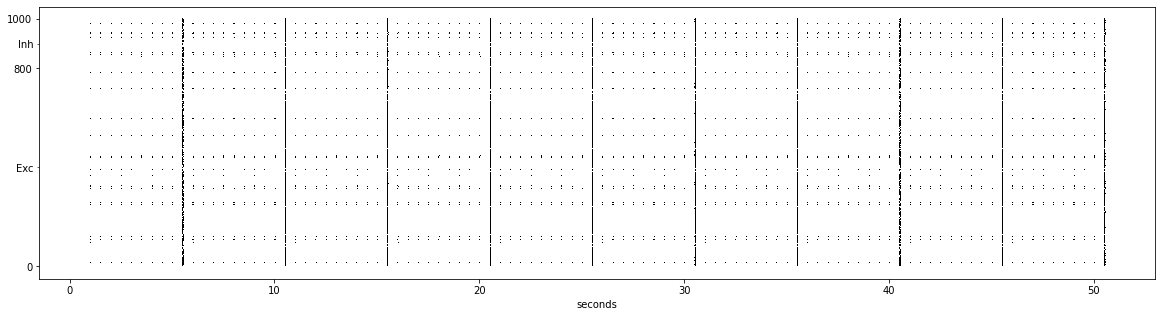

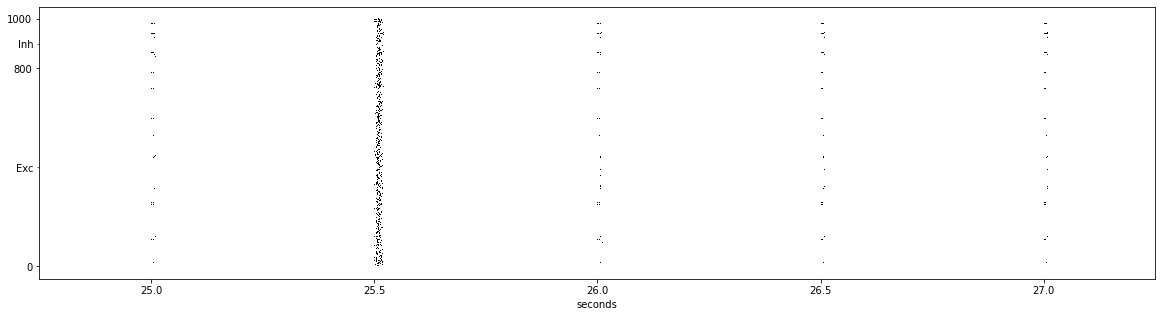

In [18]:
raster(Net)
raster(Net).set_xlim(47.5*params['ISI'] + params['settling_period'], 52.5*params['ISI'] + params['settling_period']);

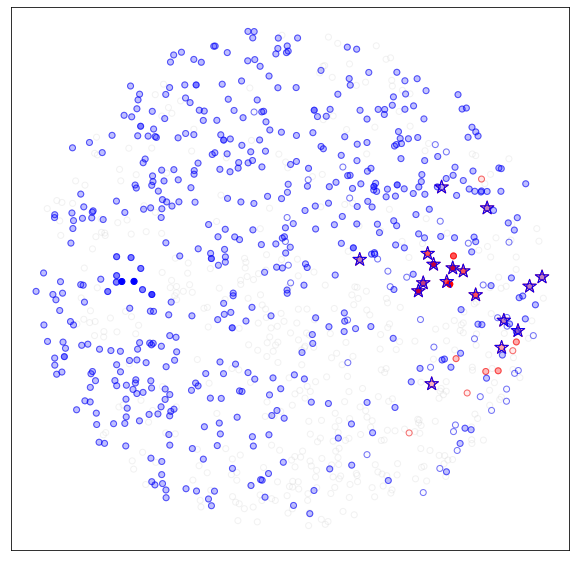

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
draw_active_neurons(Net, X, Y, ax, Astd, (A,B), ('r', 'b'))

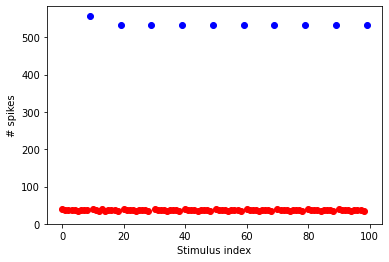

In [20]:
plot_sequence_spikecounts(Astd, A, B)

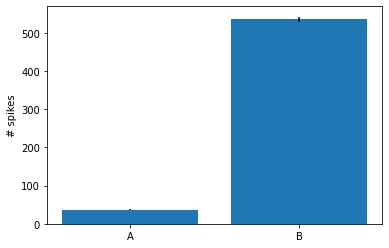

In [21]:
Astd['mean_A'], Astd['std_A'] = np.mean(Astd['nspikes'][Astd['Seq']==A]), np.std(Astd['nspikes'][Astd['Seq']==A])
Astd['mean_B'], Astd['std_B'] = np.mean(Astd['nspikes'][Astd['Seq']==B]), np.std(Astd['nspikes'][Astd['Seq']==B])
plt.bar(['A', 'B'], [Astd['mean_A'], Astd['mean_B']], yerr=[Astd['std_A'], Astd['std_B']])
plt.ylabel('# spikes');

In [22]:
device.reinit()
device.activate()

In [24]:
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params, rng)
Bstd = {}
Bstd['Seq'], T = inputs.create_oddball(Net, params, B, A)
Net.run(T)
populate_spike_results(Net, params, Bstd)

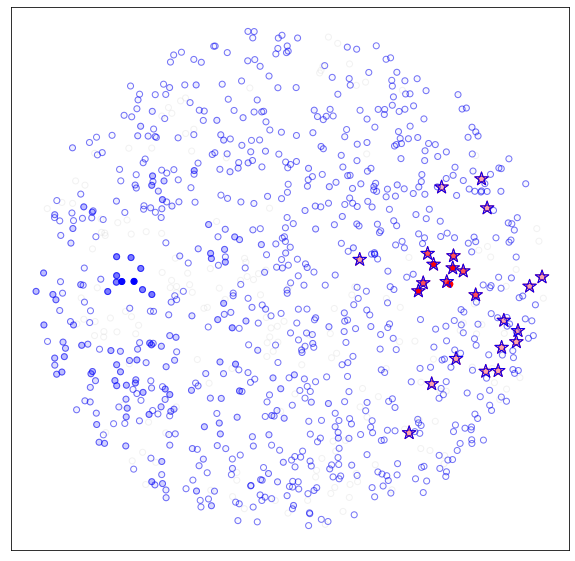

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
draw_active_neurons(Net, X, Y, ax, Bstd, (A,B), ('r', 'b'))

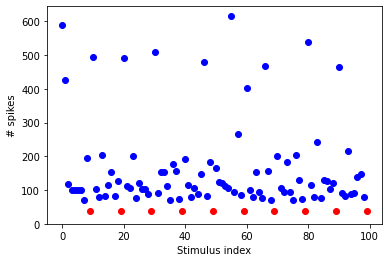

In [26]:
plot_sequence_spikecounts(Bstd, A, B)

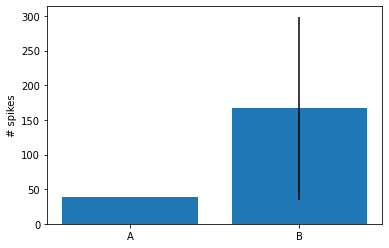

In [27]:
Bstd['mean_A'], Bstd['std_A'] = np.mean(Bstd['nspikes'][Bstd['Seq']==A]), np.std(Bstd['nspikes'][Bstd['Seq']==A])
Bstd['mean_B'], Bstd['std_B'] = np.mean(Bstd['nspikes'][Bstd['Seq']==B]), np.std(Bstd['nspikes'][Bstd['Seq']==B])
plt.bar(['A', 'B'], [Bstd['mean_A'], Bstd['mean_B']], yerr=[Bstd['std_A'], Bstd['std_B']])
plt.ylabel('# spikes');

In [28]:
device.reinit()
device.activate()

In [29]:
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params, rng)
MSC = {}
MSC['Seq'], T = inputs.create_MSC(Net, params, rng)
Net.run(T)
populate_spike_results(Net, params, MSC)

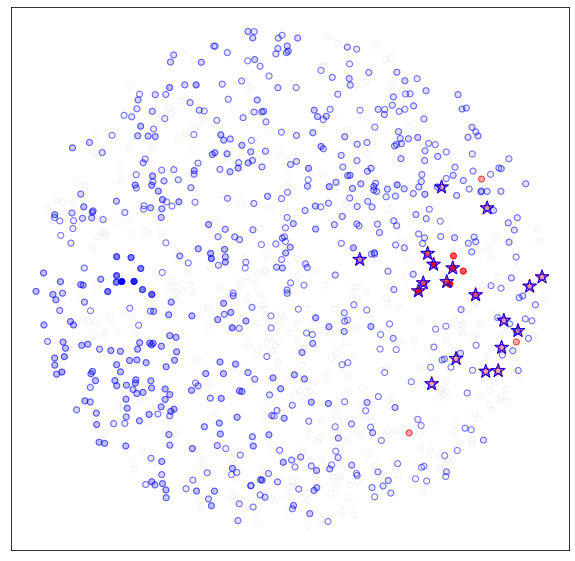

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
draw_active_neurons(Net, X, Y, ax, MSC, (A,B), ('r', 'b'))

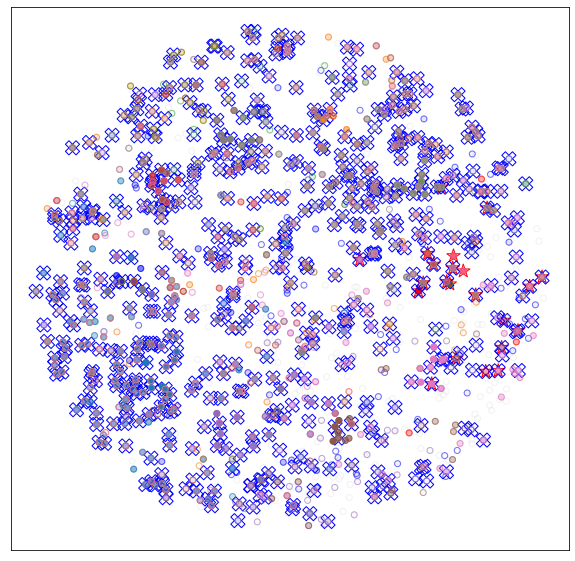

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
draw_active_neurons(
    Net, X, Y, ax, MSC,
    (A, B, *[x for x in MSC['Seq'][:10] if x not in (A,B)]),
    ('r', 'b', *[f'C{i}' for i in range(10)]),
    overlaps={A: '*', B: 'X'})

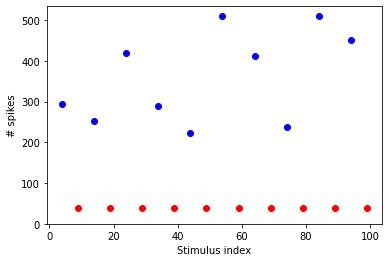

In [32]:
plot_sequence_spikecounts(MSC, A, B)

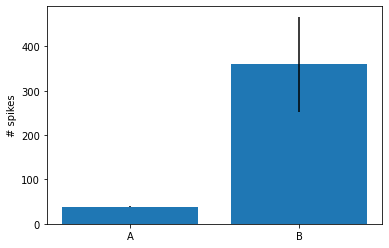

In [33]:
MSC['mean_A'], MSC['std_A'] = np.mean(MSC['nspikes'][MSC['Seq']==A]), np.std(MSC['nspikes'][MSC['Seq']==A])
MSC['mean_B'], MSC['std_B'] = np.mean(MSC['nspikes'][MSC['Seq']==B]), np.std(MSC['nspikes'][MSC['Seq']==B])
plt.bar(['A', 'B'], [MSC['mean_A'], MSC['mean_B']], yerr=[MSC['std_A'], MSC['std_B']])
plt.ylabel('# spikes');

In [34]:
nspikes_std = np.concatenate([Astd['nspikes'][Astd['Seq']==A], Bstd['nspikes'][Bstd['Seq']==B]])
nspikes_dev = np.concatenate([Astd['nspikes'][Astd['Seq']==B], Bstd['nspikes'][Bstd['Seq']==A]])
nspikes_msc = np.concatenate([MSC['nspikes'][MSC['Seq']==A], MSC['nspikes'][MSC['Seq']==B]])
mean_std, stddev_std = nspikes_std.mean(), nspikes_std.std()
mean_dev, stddev_dev = nspikes_dev.mean(), nspikes_dev.std()
mean_msc, stddev_msc = nspikes_msc.mean(), nspikes_msc.std()
contrast_dev_std = (mean_dev - mean_std) / (mean_dev + mean_std)
contrast_dev_msc = (mean_dev - mean_msc) / (mean_dev + mean_msc)
print(f'SSA index: {contrast_dev_std:.3f}\nDD index: {contrast_dev_msc:.3f}')

SSA index: 0.477
DD index: 0.180


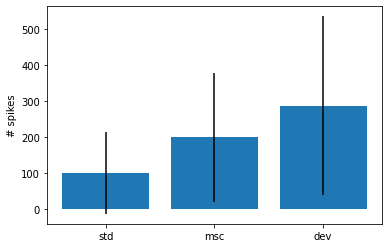

In [35]:
plt.bar(['std', 'msc', 'dev'], [mean_std, mean_msc, mean_dev], yerr=[stddev_std, stddev_msc, stddev_dev])
plt.ylabel('# spikes');

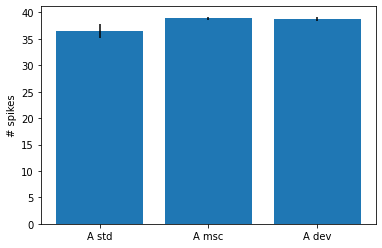

In [36]:
plt.bar(['A std', 'A msc', 'A dev'], [Astd['mean_A'], MSC['mean_A'], Bstd['mean_A']], yerr=[Astd['std_A'], MSC['std_A'], Bstd['std_A']])
plt.ylabel('# spikes');

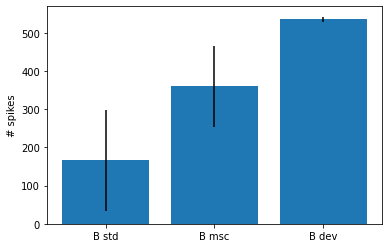

In [37]:
plt.bar(['B std', 'B msc', 'B dev'], [Bstd['mean_B'], MSC['mean_B'], Astd['mean_B']], yerr=[Bstd['std_B'], MSC['std_B'], Astd['std_B']])
plt.ylabel('# spikes');

In [38]:
# device.reinit()
# device.activate()
# Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
# Bstd = {}
# Bstd['Seq'], T = create_oddball(Net, params, B, A)
# Net.run(T)
# Bstd['nspikes'] = get_pulse_spike_counts(Net, params)
# plt.scatter(np.arange(len(Bstd['nspikes'])), Bstd['nspikes'], c=np.where(Bstd['Seq']==A, 'b', 'r'))
# plt.ylim(bottom=0)
# plt.ylabel('# spikes')
# plt.xlabel('Stimulus index');
# Bstd['mean_A'], Bstd['std_A'] = np.mean(Bstd['nspikes'][Bstd['Seq']==A]), np.std(Bstd['nspikes'][Bstd['Seq']==A])
# Bstd['mean_B'], Bstd['std_B'] = np.mean(Bstd['nspikes'][Bstd['Seq']==B]), np.std(Bstd['nspikes'][Bstd['Seq']==B])
# plt.bar(['A', 'B'], [Bstd['mean_A'], Bstd['mean_B']], yerr=[Bstd['std_A'], Bstd['std_B']])
# plt.ylabel('# spikes');